## **Import files and dependancies**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:
df = pd.read_csv('/content/Credit_N400_p9.csv')

In [4]:
# read in the data into a pandas dataframe
df = pd.read_csv('Credit_N400_p9.csv')
df.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580


## **Data pre Proccessing**

In [5]:
# recode the gender, student, and married X_p 
df['Gender'].replace(to_replace = dict(Female = 0, Male = 1), inplace=True)
df['Student'].replace(to_replace = dict(No = 0, Yes = 1), inplace=True)
df['Married'].replace(to_replace = dict(No = 0, Yes = 1), inplace=True)
df.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,1,0,1,333
1,106.025,6645,483,3,82,15,0,1,1,903
2,104.593,7075,514,4,71,11,1,0,0,580


In [6]:
# separate the predictors from the response
X = df.to_numpy()[:, :-1]
Y = df.to_numpy()[:, -1]
print(X.shape, Y.shape)

(400, 9) (400,)


## **Elastic Net CV Class**

In [19]:
class ElasticNetCoordinateDecent:
    def __init__(self, X, Y, λ, α, k_folds = 5, i = 1000, verbose = True):
        # Initialize constructor variables
        self.x, self.y = self.randomize_data(X, Y)
        self.λ = λ 
        self.α = α      
        self.k_folds = k_folds 
        self.i = i
        self.verbose = verbose
        self.build_CV()

# Build Cross validate design matrix
    def build_CV(self):

        # get number of samples and number of features
        self.X1 = self.x.shape[0]
        self.X2 = self.x.shape[1]
    
        # matrix to store the cross validation results 
        self.CV = np.zeros([self.k_folds, len(self.λ), len(self.α)])

        # determine the number of validation samples and their inds based on k_folds 
        self.test_x = self.X1 // self.k_folds 
        self.test_i = list(range(0, self.X1, self.test_x))
        
        # Print CV split output
        if self.verbose:
            print('[INFO] Implementing CV 5 K-fold {} training of {} validation samples'.format(self.X1 - self.test_x, self.test_x))

        # create a matrix to store the predictors
        self.𝛽 = np.zeros([self.k_folds, len(self.λ), len(self.α), self.X2])

# standardize X features
    def standardize(self, x, mean_x, std_x):
        return (x - mean_x) / std_x 

# Center respose variables
    def center_responses(self, y, mean):
        return y - mean


# predict X
    def predict(self, x):
        assert(self.mean_x is not None and self.std_x is not None), \
            'Model must be trained before predicting.'
        x = self._standardize(x, self.mean_x, self.std_x)
        return np.matmul(x, self.𝛽x)

# Randomize data
    def randomize_data(self, X, Y):
        M = np.concatenate((X, Y[:, None]), 1)
        np.random.shuffle(M)
        return M[:, :-1], M[:, -1]
        
# Initialize beta coefficients
    def coef_init(self):
        return np.random.uniform(low = -1, high = 1, size = (self.X2, 1))

 # return MSE Score
    def MSE(self, x, y, 𝛽x):
        ŷ = np.matmul(x, 𝛽x)
        mse = np.mean((y - ŷ) ** 2)
        return mse

# Return Sum of squares    
    def sum_sq(self, x):
        return np.sum(x ** 2, 0)
  
# Implement K-fold Cross vlaiadtion
    def k_folds(self, i_test):
        x_test = self.x[i_test:i_test + self.test_x]
        x_train = np.delete(self.x, np.arange(i_test, i_test + self.test_x), axis = 0)
        y_test = self.y[i_test:i_test + self.test_x]
        y_train = np.delete(self.y, np.arange(i_test, i_test + self.test_x), axis = 0)
        return x_train, x_test, y_train, y_test


# Find best tuning and alpha params    
    def best_λ_params(self):
        cv_mean = np.mean(self.CV, 0)
        best_λ_ind, best_alpha_ind = np.where(cv_mean == np.amin(cv_mean))
        self.best_λ = self.λ[best_λ_ind[0]]
        self.best_alpha = self.α[best_alpha_ind[0]]

# Implment Coordinate Descent
    def coordinateDescent(self, x, y, 𝛽x, sum_sq, lambda_, alpha):
        for k in range(self.X2):
            # get rss without the effect of coefficient k
            RSS = y - np.matmul(x, 𝛽x) + (x[:, k] * 𝛽x[k])[:, None]
            
            # a_k is part of the derivative of the rss term in the loss function
            a_k = np.matmul(x[:, k].transpose(), RSS)[0]
            
            # update B_k
            𝛽k = 𝛽k if 𝛽k >= 0 else 0
            𝛽x[k, 0] = np.sign(a_k) * B_k / (sum_sq[k] + lambda_ * alpha) 
        return B

# Fit data with elastic net CV and coordiante decent algorithm
    def elasticNetCV(self):
        for i_lambda, lambda_ in enumerate(self.λ): # loop through λ
            for i_alpha, alpha in enumerate(self.α): # loop through α
                for i_fold, i_test in zip(range(self.k_folds), self.test_i): # loop through folds
                    # get the folds
                    x_train, x_test, y_train, y_test = self.k_folds(i_test)

                    # standardize x and center y
                    mean_x, std_x = np.mean(x_train, 0), np.std(x_train, 0)
                    mean_response = np.mean(y_train)

                    # standardize x and center y through CV 
                    x_train = self.standardize(x_train, mean_x, std_x)
                    x_test = self.standardize(x_test, mean_x, std_x)
                    y_train = self.center_responses(y_train, mean_response)[:, None]
                    y_test = self.center_responses(y_test, mean_response)[:, None]
                    
                    # compute b_k given this fold -- don't need to compute every update
                    sum_sq = self.sum_sq(x_train)

                    # initialize Beta for this lambda and fold
                    𝛽x = self.coef_init()

                    for iter in range(self.iterations):
                        𝛽x = self.coordinateDescent(x_train, y_train, 𝛽x, sum_sq, lambda_, alpha)
                        
                    # score this model 
                    mse_score = self.MSE(x_test, y_test, 𝛽x)

                    # store the score with the tuning param combinations
                    self.CV[i_fold, i_lambda, i_alpha] = mse_score

                    # store the coefficient vector
                    self.𝛽[i_fold, i_lambda, i_alpha] = 𝛽x[:, 0]
                    
                # if verbose flag, then print out the mean CV MSE for the combo of lambda and alpha
                if self.verbose:
                    print('lambda:{}; alpha:{}; CV MSE:{}'.format(lambda_, alpha, np.mean(self.CV[:, i_lambda, i_alpha])))
                    

#Retrain model with the optimal lambda and alpha
                    
        # find the best lambda and alpha
        self.best_λ_params()
        
        # standardize features of x and center responses 
        self.mean_x, self.std_x = np.mean(self.x, 0), np.std(self.x, 0)
        x = self._standardize(self.x, self.mean_x, self.std_x)
        y = self._center_responses(self.y, np.mean(self.y))[:, None]
        
        # compute the sum of squares for each feature on the entire dataset
        sum_sq = self.sum_sq(x)
        
        # initialize coefficients
        self.𝛽x= self.coef_init()
        
        # perform updates 
        for iter in range(self.i):
            self.𝛽x = self.coordinateDescent(x, y, self.𝛽x, sum_sq, self.best_λ, self.best_alpha)

In [20]:
# instantiate the model 
elastic_net = ElasticNetCoordinateDecent(
    X = X,
    Y = Y,
    λ = 10 ** np.arange(-2., 7.),
    α = [0, 0.2, 0.4, 0.6, 0.8, 1.0],
    i = 1000,
    verbose = True
)

[INFO] Implementing CV 5 K-fold 320 training of 80 validation samples


In [ ]:
# fit the model
elastic_net.elasticNetCV()

lambda:0.01; alpha:0; CV MSE:10152.932986338876
lambda:0.01; alpha:0.2; CV MSE:10152.837908294616
lambda:0.01; alpha:0.4; CV MSE:10152.7366636697
lambda:0.01; alpha:0.6; CV MSE:10152.624416629289
lambda:0.01; alpha:0.8; CV MSE:10152.537901264554
lambda:0.01; alpha:1.0; CV MSE:10152.434911240125
lambda:0.1; alpha:0; CV MSE:10152.93432348739
lambda:0.1; alpha:0.2; CV MSE:10151.986940380555
lambda:0.1; alpha:0.4; CV MSE:10151.243778764952
lambda:0.1; alpha:0.6; CV MSE:10150.674087655785
lambda:0.1; alpha:0.8; CV MSE:10150.249494193285
lambda:0.1; alpha:1.0; CV MSE:10149.9472797876
lambda:1.0; alpha:0; CV MSE:10152.928022836708
lambda:1.0; alpha:0.2; CV MSE:10149.874781082974
lambda:1.0; alpha:0.4; CV MSE:10153.46013059928
lambda:1.0; alpha:0.6; CV MSE:10158.898462985613
lambda:1.0; alpha:0.8; CV MSE:10164.974758485125
lambda:1.0; alpha:1.0; CV MSE:10171.36837554682
lambda:10.0; alpha:0; CV MSE:10152.788921122843
lambda:10.0; alpha:0.2; CV MSE:10208.017242434205
lambda:10.0; alpha:0.4; CV 

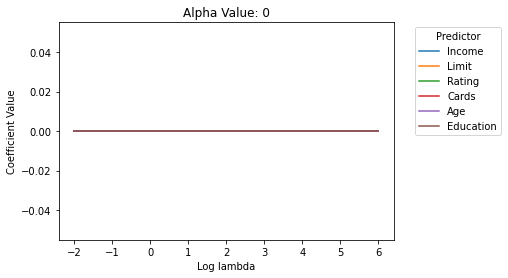

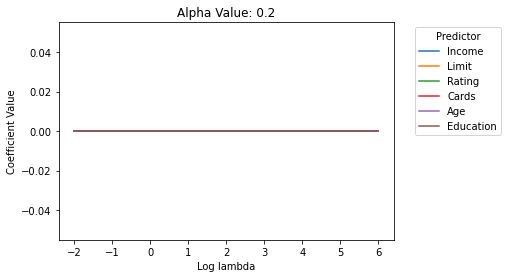

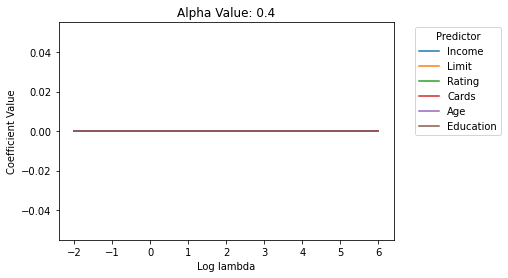

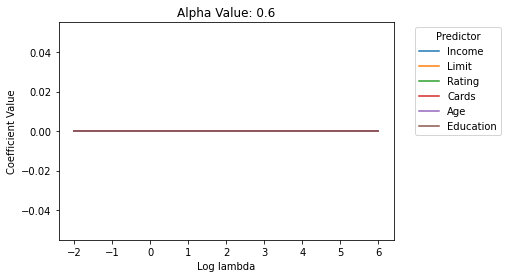

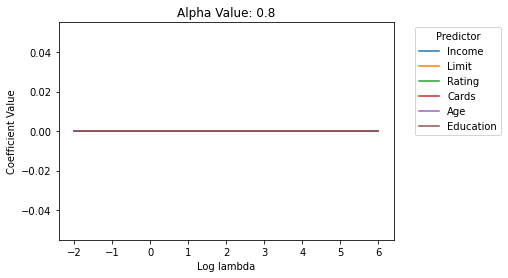

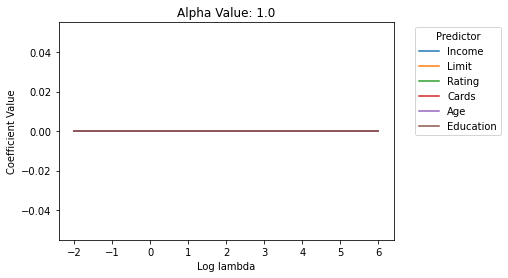

In [22]:
# observe the coefficient values as a function of lambda for each alpha
# plotting mean coefficient vectors over the 5 folds
mean_betas = np.mean(elastic_net.𝛽, 0)
pred_names = df.columns

for i_alpha, alpha in enumerate(elastic_net.α):
    for i_beta in range(mean_betas.shape[1]):
        plt.plot(
            np.log10(elastic_net.λ), 
            mean_betas[:, i_alpha, i_beta],  
            label = pred_names[i_beta]
        )
    plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left', title = 'Predictor')
    plt.xlabel('Log lambda')
    plt.ylabel('Coefficient Value')
    plt.title('Alpha Value: {}'.format(alpha))
    plt.show()
    plt.close()

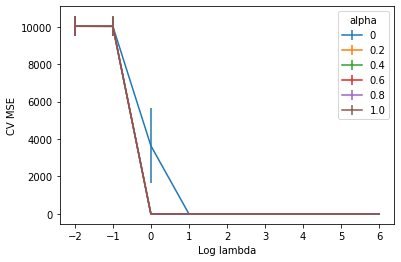

In [ ]:
# observe the CV MSE over values of lambda and alpha
for i_alpha, alpha in enumerate(elastic_net.α):
    se = np.std(elastic_net.CV[..., i_alpha], 0) / np.sqrt(elastic_net.k_folds)
    plt.errorbar(
        np.log10(elastic_net.λ), 
        np.mean(elastic_net.CV[..., i_alpha], 0), 
        yerr = se,
        label = str(alpha)
    )
    plt.xlabel('Log lambda')
    plt.ylabel('CV MSE')
    
plt.legend(title = 'alpha')
plt.show()

In [ ]:
# lambda and alpha with lowest cv mse
print('Best lambda: {}; Best alpha: {}'.format(
    elastic_net.best_λ, elastic_net.best_alpha)
)

Best lambda: 1.0; Best alpha: 0.4


In [ ]:
# coefficient vector for optimal lambda and alpha
elastic_net.B

array([[-273.29350534],
       [ 401.17294292],
       [ 212.98359435],
       [  22.73251213],
       [ -11.08420954],
       [  -3.23407083],
       [   5.15773024],
       [ 127.51209263],
       [  -3.7356926 ]])

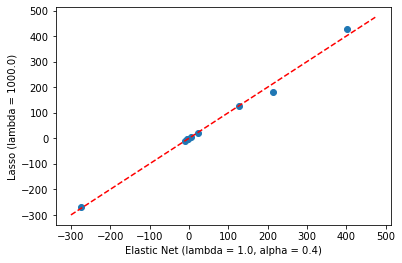

In [ ]:
# coefficient vector for optimal lambda given alpha = 0 (lasso)
# coefficicents look relatively similar to elastic net

# get cv mse given alpha = 0
alpha_0 = np.mean(elastic_net.CV[..., 0], 0)

# find index of lambda with lowest cv mse
lambda_index = np.argmin(alpha_0)
lambda_best = elastic_net.λ[lambda_index]

# get the mean coefficient vector under lambda and alpha for all 5 folds
𝛽_mean = np.mean(elastic_net.𝛽[:, lambda_ind, 0, :], 0)

# plot against B with optimal lambda and alpha
plt.scatter(elastic_net.𝛽 , 𝛽_mean)
plt.plot(np.arange(-300, 475), np.arange(-300, 475), '--', color = 'r')
plt.xlabel('Elastic Net (lambda = {}, alpha = {})'.format(elastic_net.best_λ, elastic_net.best_alpha))
plt.ylabel('Lasso (lambda = {})'.format(lambda_best))
plt.show()

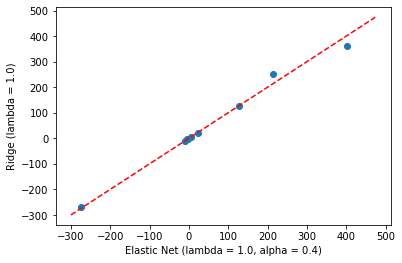

In [ ]:
# coefficient vector for optimal lambda given alpha = 1 (ridge)
# coefficients look similar to elastic net and lasso
# because best alpha was in the middle

# get cv mse given alpha = 1
cv_mse_alpha_1 = np.mean(elastic_net.CV[..., -1], 0)

# find index of lambda with lowest cv mse
lambda_ind = np.argmin(cv_mse_alpha_1)
lambda_optimal = elastic_net.λ[lambda_ind]

# get the mean coefficient vector under lambda and alpha for all 5 folds
B_mean = np.mean(elastic_net.𝛽[:, lambda_ind, -1, :], 0)

# plot against B with optimal lambda and alpha
plt.scatter(elastic_net.𝛽 , B_mean)
plt.plot(np.arange(-300, 475), np.arange(-300, 475), '--', color = 'r')
plt.xlabel('Elastic Net (lambda = {}, alpha = {})'.format(elastic_net.best_λ, elastic_net.best_alpha))
plt.ylabel('Ridge (lambda = {})'.format(lambda_optimal))
plt.show()

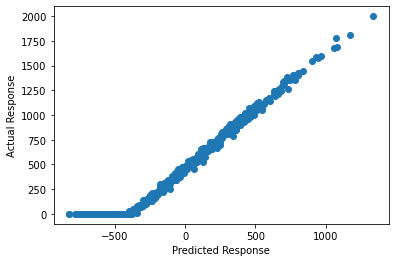

In [ ]:
# predict responses and compare against actual responses
y_hat = elastic_net.predict(elastic_net.x)
plt.scatter(y_hat, elastic_net.y)
plt.xlabel('Predicted Response')
plt.ylabel('Actual Response')
plt.show()